In [1]:
# Try to set as many seeds as I can so that keras model is reproducible
# But I failed...
# Reference (seed): https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Reference (seed): https://github.com/keras-team/keras/issues/2743
from PIL import Image
import numpy as np
import os
from matplotlib import pyplot as plt
import re
import random
import cv2
random.seed(251)
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import tensorflow as tf
tf.compat.v1.set_random_seed(251)

Using TensorFlow backend.


In [2]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_train = 'train_optical_flow_output_crop_2'
dir_test = 'val_optical_flow_output_crop_2'

test_image = 'mask_AGAIN_c4_train_ql2160.png'

image_shape = (450, 360)

In [3]:
# Reference (convert to gray-scaled image): https://brohrer.github.io/convert_rgb_to_grayscale.html
# color_img_arr = np.asarray(Image.open(os.path.join(project_path, dir_train, test_image)))
# gray_img_arr = np.mean(color_img_arr, axis=2)
color_img = cv2.imread(os.path.join(project_path, dir_train, test_image))
color_resize = cv2.resize(color_img, image_shape, interpolation=cv2.INTER_AREA)
color_img_arr = np.array(color_resize)
# Green color is (0, 255, 0)
# mean => (0, 255/3, 0), we don't want that => use sum
gray_img_arr = np.sum(color_img_arr, axis=2)
print(gray_img_arr)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


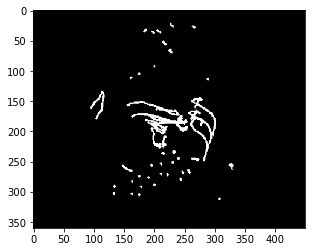

In [4]:
# Reference: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
test_image2 = Image.fromarray(gray_img_arr)
plt.imshow(test_image2)

In [5]:
train_file_lst = [f for f in os.listdir(os.path.join(project_path, dir_train)) 
                  if f[-4:]=='.png' and f[:5] == 'mask_' and re.search('_train_', f)]
val_file_lst = [f for f in os.listdir(os.path.join(project_path, dir_train)) 
                  if f[-4:]=='.png' and f[:5] == 'mask_' and re.search('_val_', f)]  

In [6]:
# List all the vocab 
all_vocab = set([f.split('_')[1] for f in os.listdir(os.path.join(project_path, dir_train))])
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(all_vocab))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(all_vocab,range(len(all_vocab))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
8


In [7]:
def file_lst_to_array(proj_path, in_dir, in_f_list):
    out_x_arr = []
    out_y_arr = []
    for f in in_f_list:
        in_img = cv2.imread(os.path.join(proj_path, in_dir, f))
        in_img_resize = cv2.resize(in_img, image_shape, interpolation=cv2.INTER_AREA)
        in_img_resize_arr = np.array(in_img_resize)
        # convert to black-white image
        out_img_arr = np.mean(in_img_resize_arr, axis=2)
        out_x_arr.append(out_img_arr)
        
        temp_vocab = f.split('_')[1]
        temp_ind = conv_vocab_to_index(temp_vocab) 
        out_y_arr.append(temp_ind)
    return np.array(out_x_arr), np.array(out_y_arr)


In [8]:
x_train, y_train = file_lst_to_array(project_path, dir_train, train_file_lst)
print(x_train.shape)
print(y_train.shape)
x_val, y_val = file_lst_to_array(project_path, dir_train, val_file_lst)
print(x_val.shape)
print(y_val.shape)

# Reference (reshape for Keras): https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
x_train = x_train.reshape(x_train.shape[0], image_shape[1], image_shape[0], 1)
x_val = x_val.reshape(x_val.shape[0], image_shape[1], image_shape[0], 1)
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

x_train = x_train / 255
x_val = x_val / 255

(78, 360, 450)
(78,)
(78, 360, 450)
(78,)


In [9]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [10]:
# Reference (model): https://medium.com/@randerson112358/classify-images-using-convolutional-neural-networks-python-a89cecc8c679
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(20, 20), strides=5, activation='relu', input_shape=(image_shape[1], image_shape[0], 1)))
# Reference (Batch Normalization): https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5)))
# model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(100, activation='relu'))
model.add(Dense(19, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 69, 87, 8)         3208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 17, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1768)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1768)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                33611     
Total params: 36,819
Trainable params: 36,819
Non-trainable params: 0
_________________________________________________________________


In [12]:
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=16, epochs=10, validation_data=(x_val, y_val_one_hot))

Train on 78 samples, validate on 78 samples
Epoch 1/10
78/78 [==============================] - 2s 22ms/step - loss: 2.9560 - accuracy: 0.0769 - val_loss: 2.8810 - val_accuracy: 0.1538
Epoch 2/10
78/78 [==============================] - 2s 20ms/step - loss: 2.8464 - accuracy: 0.1795 - val_loss: 2.7564 - val_accuracy: 0.2051
Epoch 3/10
78/78 [==============================] - 2s 20ms/step - loss: 2.6610 - accuracy: 0.1795 - val_loss: 2.5417 - val_accuracy: 0.1795
Epoch 4/10
78/78 [==============================] - 2s 20ms/step - loss: 2.4705 - accuracy: 0.1795 - val_loss: 2.2979 - val_accuracy: 0.2051
Epoch 5/10
78/78 [==============================] - 2s 20ms/step - loss: 2.1417 - accuracy: 0.2692 - val_loss: 1.9381 - val_accuracy: 0.4487
Epoch 6/10
78/78 [==============================] - 2s 21ms/step - loss: 1.7766 - accuracy: 0.4231 - val_loss: 1.5368 - val_accuracy: 0.6410
Epoch 7/10
78/78 [==============================] - 2s 20ms/step - loss: 1.4027 - accuracy: 0.5897 - val_loss:

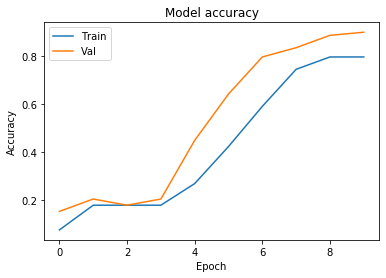

In [13]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
# Save model
model.save(os.path.join(project_path, "model3.h5"))

In [15]:
# Load model
# Reference: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_saved = load_model(os.path.join(project_path, "model3.h5"))

# Should expect .fit() and .evaluate() produce difference loss
# Reference: https://github.com/keras-team/keras/issues/6977
#   Even without dropout or batch normalization, the problem will persist. 
#   The reason for this is that when you use fit, at each batch of the training data the weights are updated. 
#   The loss value returned by the fit method is not the mean of the loss of the final model, 
#   but the mean of the loss of all slightly different models used on each batch.
#   On the other hand, when you use evaluate, the same model is used on the whole dataset. 
#   And this model actually doesn't even appear in the loss of the fit method since even at the last batch of training, 
#   the loss computed is used to update the model's weights.
model_saved.evaluate(x_train, y_train_one_hot)

78/78 [==============================] - 0s 4ms/step


[0.412143071492513, 0.9358974099159241]

In [16]:
model_saved.evaluate(x_val, y_val_one_hot)



78/78 [==============================] - 0s 3ms/step


[0.46617260040381014, 0.8974359035491943]

In [35]:
predictions = model.predict(x_train[:1])
predictions



array([[0.00974073, 0.48833394, 0.03009786, 0.03841343, 0.1288259 ,
        0.02758614, 0.01412047, 0.00933346, 0.04744824, 0.02171466,
        0.00151038, 0.00958839, 0.03275345, 0.00337356, 0.00451206,
        0.07448179, 0.02275277, 0.02167122, 0.01374166]], dtype=float32)

In [119]:
test_file_lst_all = [f for f in os.listdir(os.path.join(project_path, dir_test)) 
                  if f[-4:]=='.png' and f[:5] == 'mask_']  
len(test_file_lst_all)
test_file_lst = test_file_lst_all[70:80]
test_file_lst

['mask_AWKWARD_c5_ql170.png',
 'mask_AWKWARD_c5_ql239.png',
 'mask_AWKWARD_c5_ql270.png',
 'mask_AWKWARD_c5_ql360.png',
 'mask_AWKWARD_c5_ql420.png',
 'mask_AWKWARD_c5_ql430.png',
 'mask_AWKWARD_c5_ql479.png',
 'mask_AWKWARD_c5_ql530.png',
 'mask_AWKWARD_c5_ql740.png',
 'mask_AWKWARD_c5_ql820.png']

In [120]:
x_test, y_test = file_lst_to_array(project_path, dir_test, test_file_lst)
print(x_test.shape)
print(y_test.shape)

# Reference (reshape for Keras): https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
x_test = x_test.reshape(x_test.shape[0], 480, 640, 1)
y_test_one_hot = to_categorical(y_test)

x_test = x_test / 255


(10, 480, 640)
(10,)


In [121]:
test_output = model_saved.predict(x_test)

In [122]:
test_output

array([[0.03896625, 0.02355763, 0.08485974, 0.01830396, 0.04483627,
        0.00836084, 0.0197768 , 0.06049855, 0.12750104, 0.08474003,
        0.01226413, 0.03594411, 0.02923045, 0.01027157, 0.01909189,
        0.15578242, 0.08189144, 0.12686808, 0.0172549 ],
       [0.04818691, 0.02312476, 0.07567016, 0.02417914, 0.04666214,
        0.00902285, 0.01824917, 0.06651968, 0.11658747, 0.08793095,
        0.01258745, 0.03715259, 0.02757401, 0.01019466, 0.02107343,
        0.15158616, 0.07815862, 0.12808001, 0.01745977],
       [0.05100266, 0.02382007, 0.07743371, 0.02615315, 0.04777493,
        0.00918247, 0.0183443 , 0.06430879, 0.11548936, 0.0848537 ,
        0.01271059, 0.03817791, 0.02623484, 0.00986941, 0.02191496,
        0.15027907, 0.07636852, 0.12859496, 0.01748664],
       [0.05092959, 0.02448176, 0.07635372, 0.02689378, 0.04978972,
        0.00922853, 0.01855514, 0.06625232, 0.11870958, 0.08791691,
        0.0128739 , 0.03704337, 0.02432921, 0.00953624, 0.02182813,
        0.145

In [123]:
np.argmax(np.mean(test_output, axis=0))


15

In [124]:
conv_vocab_to_index(test_file_lst[0].split('_')[1])


14

In [125]:
np.argmax(test_output, axis=1)


array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15], dtype=int64)

In [126]:
# voting: 1
